### Datasets

All datasets are initially downloaded from [aicrowd](), and then uploaded to Kaggle to have them available there. This saves a lot of time on reloading the data when opening the notebook or running a new run. 

Import datasets from Kaggle directory of jaflaten 
the datasets are 
- food-testing
- food-validation
- food-training


Optional: Checking if the files are in place

In [1]:
!ls /kaggle/input/food-training


annotations.json  images


### Importing dependencies
Importing all the dependencies needed for training the model

In [2]:
from fastai.vision.all import *
import numpy as np
import pandas as pd
import random
from PIL import Image
import os
import json
from pathlib import Path
from fastai.metrics import Precision, Recall, accuracy
import timm

### Defining paths for datasets
Defining the paths for the training and validation set images.

In [3]:
#define paths

path_validation = Path("/kaggle/input/food-validation/images/")
path_training = Path("/kaggle/input/food-training/images/")

### Loading the metadata 
The annotations.json file is a structure of information which includes a image_id and a category_id which are important when labelling the data. 

Here I load the metadata annotations.json for both training and validation set and creating a mapping between the category id and the name 


In [4]:
# Load annotations file
train_annotations_path = Path("/kaggle/input/food-training/annotations.json")
val_annotations_path = Path("/kaggle/input/food-validation/annotations.json")

with open(train_annotations_path) as f:
    train_annotations = json.load(f)
    
with open(val_annotations_path) as f:
    val_annotations = json.load(f)    

# Create a dictionary mapping category IDs to their names
categories = {}
for category in train_annotations["categories"]:
    categories[category["id"]] = category["name"]


The annotations.json data is loaded and added to a Pandas Dataframe for each dataset, one for training and one for validation.


In [5]:
with open(train_annotations_path) as json_data:
    data = json.load(json_data)
    df_train_annotations = pd.DataFrame(data['annotations'])
    
with open(val_annotations_path) as json_data:
    data = json.load(json_data)
    df_val_annotations = pd.DataFrame(data['annotations'])    

Checking the output from each dataframe to verify it looks reasonable

In [6]:
df_train_annotations.head(2)

,id,image_id,category_id,segmentation,area,bbox,iscrowd
0,184135,131094,1352,"[[115.0, 206.5, 98.0, 204.5, 74.5, 182.0, 65.0, 167.5, 47.5, 156.0, 39.5, 137.0, 39.5, 130.0, 51.0, 118.5, 62.00000000000001, 112.5, 76.0, 113.5, 121.5, 151.0, 130.5, 169.0, 131.5, 185.0, 128.5, 195.0]]",5059.0,"[39.5, 39.5, 167.0, 92.0]",0
1,184136,131094,1893,"[[182.2599609375, 210.67999877929685, 58.6599609375, 227.4799987792969, 9.459960937500002, 229.8799987792969, 8.2599609375, 341.4799987792969, 14.2599609375, 375.07999877929694, 49.059960937499994, 355.87999877929684, 64.6599609375, 327.0799987792969, 93.4599609375, 307.8799987792969, 139.0599609375, 305.47999877929686, 178.65996093750002, 307.8799987792969, 195.4599609375, 303.0799987792969, 196.6599609375, 270.67999877929685, 182.2599609375, 232.27999877929685, 181.05996093750002, 227.4799987792969]]",18642.0,"[8.2599609375, 8.2599609375, 366.82003784179693, 188.39999999999998]",0


In [7]:
df_val_annotations.head(2)


,id,image_id,category_id,segmentation,area,bbox,iscrowd
0,233459,149022,2504,"[[214.0, 152.5, 175.0, 144.5, 156.5, 133.0, 153.5, 119.0, 159.5, 99.0, 168.0, 89.5, 191.0, 77.5, 231.99999999999997, 73.5, 258.0, 80.5, 279.5, 95.0, 285.5, 104.0, 288.5, 122.0, 278.0, 137.5, 250.00000000000003, 148.5]]",8225.0,"[77.5, 153.5, 136.5, 135.0]",0
1,237814,149022,2131,"[[327.315625, 304.90686111450196, 83.890625, 271.919361114502, 65.690625, 361.78186111450196, 319.35312500000003, 409.556861114502, 320.49062499999997, 312.86936111450194]]",24367.0,"[65.690625, 65.690625, 261.625, 261.625]",0


### Merging datasets
Here the training and validation datasets are merged into one make it easier to use when we will create a ImageDataLoader later.

In [8]:
df_annotations = pd.concat([df_train_annotations, df_val_annotations])

In [9]:
df_annotations.head(2)

,id,image_id,category_id,segmentation,area,bbox,iscrowd
0,184135,131094,1352,"[[115.0, 206.5, 98.0, 204.5, 74.5, 182.0, 65.0, 167.5, 47.5, 156.0, 39.5, 137.0, 39.5, 130.0, 51.0, 118.5, 62.00000000000001, 112.5, 76.0, 113.5, 121.5, 151.0, 130.5, 169.0, 131.5, 185.0, 128.5, 195.0]]",5059.0,"[39.5, 39.5, 167.0, 92.0]",0
1,184136,131094,1893,"[[182.2599609375, 210.67999877929685, 58.6599609375, 227.4799987792969, 9.459960937500002, 229.8799987792969, 8.2599609375, 341.4799987792969, 14.2599609375, 375.07999877929694, 49.059960937499994, 355.87999877929684, 64.6599609375, 327.0799987792969, 93.4599609375, 307.8799987792969, 139.0599609375, 305.47999877929686, 178.65996093750002, 307.8799987792969, 195.4599609375, 303.0799987792969, 196.6599609375, 270.67999877929685, 182.2599609375, 232.27999877929685, 181.05996093750002, 227.4799987792969]]",18642.0,"[8.2599609375, 8.2599609375, 366.82003784179693, 188.39999999999998]",0


### Labelling the data

To label each image with the correct label based onthe image id I needed to iterate the annotations file and find the images with the corresponding image id similar to the name of the image file. So this function can take a given image name and return the label that should be set to that image. 

In [10]:

# Define the get_label function
def get_label(image_filename):
    image_id = int(Path(image_filename).stem.lstrip("0"))
    return categories[df_annotations.loc[df_annotations['image_id'] == image_id]['category_id'].values[0]]
    

Testing the get_lable function to verify that we get labels based on a pre-picked image. 

In [11]:
get_label("059339.jpg")

'chicken'

In [12]:
get_label("149022.jpg")

'espresso-with-caffeine'

### Modifying the dataframe
Creating a new dataframe containing two columns. One for the image name full path including the filename. For instance ```/kaggle/input/food-training/images/059339.jpg```

And one column to determine if the image is from the test or the validation set by setting the ```is_val``` to either False or True. This will be True for the validation data, and false otherwise.

At the end the two dataframes are merged together to one dataframe. 

In [13]:
df_train = pd.DataFrame(list(path_training.ls()), columns=["img"])
df_val = pd.DataFrame(list(path_validation.ls()), columns=["img"])

df_train["is_val"] = False
df_val["is_val"] = True
df = pd.concat([df_train, df_val])

Verifying dataframe content with manual inspection

In [14]:
df.head(2)

,img,is_val
0,/kaggle/input/food-training/images/059339.jpg,False
1,/kaggle/input/food-training/images/046754.jpg,False


In [15]:
df.tail(2)

,img,is_val
998,/kaggle/input/food-validation/images/146957.jpg,True
999,/kaggle/input/food-validation/images/163225.jpg,True


### Adding the labels
The last modification to the dataframe is to add another column for the label to each image, this is so the model can know what is correct and wrong when being trained. To add the model we can use the get_label function that was defined earlier and do this for every image in the dataframe

In [16]:
df['label'] = df['img'].apply(get_label)

In [17]:
df.head(2)

,img,is_val,label
0,/kaggle/input/food-training/images/059339.jpg,False,chicken
1,/kaggle/input/food-training/images/046754.jpg,False,beer


### Creating a ImageDataLoader

To create the ImageDataLoader we want to create it from the dataframe that was stitched together above. The images are being resized and scaled. The labels are set using the get_label function defined above. 

In [18]:
dls = ImageDataLoaders.from_df(df, label_col=2, valid_col=1, path="/",
                                item_tfms=Resize(192, method='squish'),
                                batch_tfms=aug_transforms(size=128, min_scale=0.75),
                                label_func=get_label)

In [19]:
#testing resize crop 
#dls.train = dls.train.new(
#    item_tfms=RandomResizedCrop(128, min_scale=0.5),
#    batch_tfms=aug_transforms(size=128, min_scale=0.75)
#)

Checking out a small sample of the images to see what they look like and that they are labeled


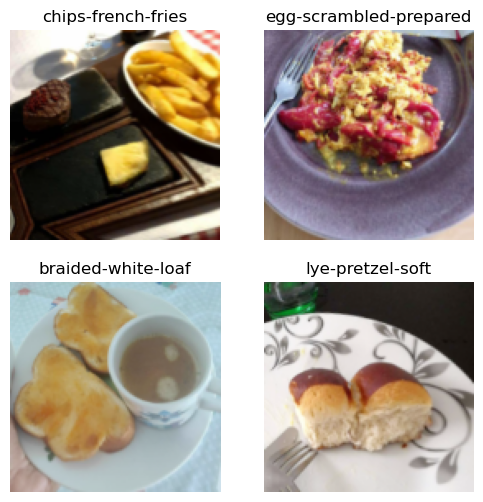

In [20]:
dls.show_batch(max_n=4)

Set a architecture to use

In [21]:
architecture = 'convnext_large_in22ft1k'
#architecture = 'convnext_small_in22k'

### Metrics and creating a vision learner

We want to have average precision, average recall and accuracy as our metrics. The AP and AR are to be able to compare the model to the leaderboards at [aicrowd](https://www.aicrowd.com/challenges/food-recognition-benchmark-2022/leaderboards). Accuracy will be a useful metric to easily see how well the model performs on the validation set. 

These are used as parameters to the vision_learner when creating a learner. We also specify the architecture to use, the DataLoaders and that we want to use a pretrained model. The last parameter will significantly help us achieve proper results when leveraging a model that has already been trained on a large dataset. 

In [22]:
average_precision = Precision(average='macro', pos_label=1)
average_recall = Recall(average='macro', pos_label=1)
learner = vision_learner(dls, architecture, metrics=[accuracy, average_precision, average_recall], pretrained=True).to_fp16()

Downloading: "https://dl.fbaipublicfiles.com/convnext/convnext_large_22k_1k_224.pth" to /root/.cache/torch/hub/checkpoints/convnext_large_22k_1k_224.pth


In [23]:
#learner = vision_learner(dls, resnet34, metrics=accuracy)
#learner = vision_learner(dls, 'convnext_small_in22k', metrics=[ap, ar]).to_fp16()

### Find learning rate
Find the optimal learning rate for the model and use it when fine tuning

0.003570668661268428


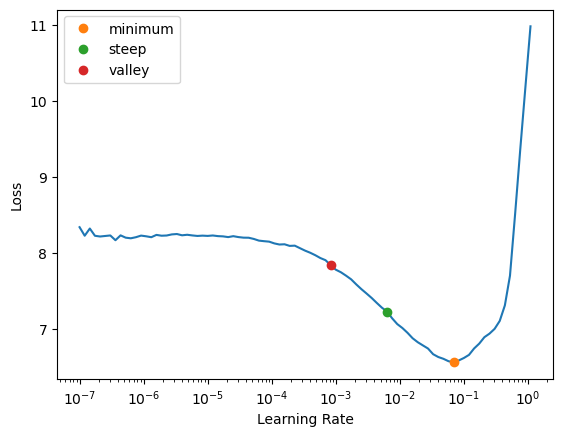

In [24]:
lr = learner.lr_find(suggest_funcs=(minimum, steep, valley), show_plot=True)
base_lr = (lr.valley + lr.steep)/2
print(base_lr)

In [25]:
learner.fine_tune(10, base_lr=base_lr)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,2.887325,2.566452,0.432000,0.242578,0.258051,10:05


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,2.078517,2.109126,0.504000,0.293830,0.304883,10:12
1,2.014747,2.045223,0.509000,0.301322,0.320068,10:13
2,1.924625,2.051094,0.497000,0.295928,0.314344,10:12
3,1.745123,2.039572,0.524000,0.325969,0.345962,10:14
4,1.441946,2.087038,0.519000,0.320270,0.328752,10:15
5,1.206127,2.113274,0.530000,0.346324,0.347171,10:15
6,0.986239,2.140767,0.529000,0.334924,0.343973,10:15
7,0.840243,2.166327,0.533000,0.344271,0.350544,10:14
8,0.721522,2.170033,0.538000,0.345912,0.354680,10:12
9,0.629604,2.168919,0.533000,0.337457,0.345615,10:13


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is 

### Error rate testing
Testing error rates with preds and targs, then tta and targs

In [26]:
# Get the validation set
valid_dl = dls.valid

# Predict on the validation set
preds, targs = learner.get_preds(dl=valid_dl)

# Print the length of predictions and targets
print(f"Number of validation set predictions: {len(preds)}")
print(f"Number of validation set targets: {len(targs)}")

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Number of validation set predictions: 1000
Number of validation set targets: 1000


In [27]:
error_rate(preds, targs)

TensorBase(0.4670)

In [28]:
tta_preds,_ = learner.tta(dl=valid_dl)

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is 

In [29]:
error_rate(tta_preds, targs)

TensorBase(0.4620)

### Export the model
Exporting the model to a file to be used in a application. 


In [30]:
learner.export(fname = '/kaggle/working/foodmodel.pkl')

In [31]:
?learner.export

In [32]:
!ls /kaggle/working


__notebook__.ipynb  foodmodel.pkl


### Export model to Huggingface
Next i want to export the model to huggingface hub to be able to use it when i host my gradio app there

Import dependencies

In [33]:
from datasets import DatasetDict
from huggingface_hub import HfApi, Repository
from kaggle_secrets import UserSecretsClient
import os
from huggingface_hub.utils._subprocess import run_subprocess
import shutil

get token from secret and clone existing repo

In [34]:
user_secrets = UserSecretsClient()
token = user_secrets.get_secret("hf-secret")

Accessing huggingface API to clone existing repo. Export model to the repository and commit and push. 

In [35]:

hf_api = HfApi()
#repo_url = hf_api.create_repo(token, "foodmodel-hf")
repo_id = "jaflaten/foodmodel"
repo = Repository("foodmodel", clone_from=repo_id, repo_type="model", use_auth_token=token)
learner.export(fname = 'foodmodel.pkl')


# Move the foodmodel.pkl file to the cloned repository directory
shutil.move('foodmodel.pkl', os.path.join(repo.local_dir, 'foodmodel.pkl'))

# Check if the file is created
print("Files in the 'foodmodel' directory:")
print(os.listdir())



# Add and commit the changes
repo.git_add(pattern="*")

# Check the git status
print("\nGit status:")
print(run_subprocess(["git", "status"], repo.local_dir).stdout)

repo.git_commit("Kaggle built and exported foodmodel.pkl")
repo.git_push()


Cloning https://huggingface.co/jaflaten/foodmodel into local empty directory.


Download file foodmodel-re.pkl:   0%|          | 24.0k/194M [00:00<?, ?B/s]

Download file foodmodel.pkl:   0%|          | 1.40k/193M [00:00<?, ?B/s]

Clean file foodmodel-re.pkl:   0%|          | 1.00k/194M [00:00<?, ?B/s]

Clean file foodmodel.pkl:   0%|          | 1.00k/193M [00:00<?, ?B/s]

Files in the 'foodmodel' directory:
['foodmodel', '__notebook__.ipynb']

Git status:
On branch main
Your branch is up to date with 'origin/main'.

Changes to be committed:
  (use "git restore --staged <file>..." to unstage)
	modified:   foodmodel.pkl




Upload file foodmodel.pkl:   0%|          | 1.00/757M [00:00<?, ?B/s]

To https://huggingface.co/jaflaten/foodmodel
   e87cc52..cacd6d8  main -> main



'https://huggingface.co/jaflaten/foodmodel/commit/cacd6d89506a39041a07ca781b374820efae32d3'